# Simultaneous Fitting of a Transit with Stellar Variability

In [104]:
import lightkurve as lk
import numpy as np
import exoplanet as xo
import matplotlib.pyplot as plt
import pandas as pd

import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess
import starry
import pdb
from astropy import constants as const
from astropy import units as u

%matplotlib inline

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


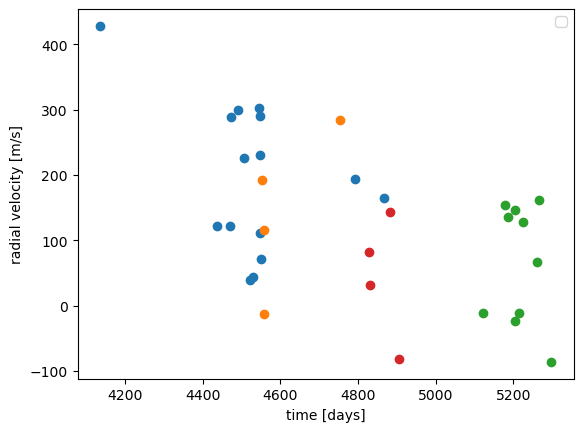

In [105]:
data = pd.read_table('hpf.dat', header = 0,
                 names = ['time', 'radial_velocity', 'rv_error', 'instrument'])

neid_he = pd.read_table('neidhe.dat', header = 0,
                 names = ['time', 'radial_velocity', 'rv_error', 'instrument'])
neid_hr = pd.read_table('neidhr.dat', header = 0,
                 names = ['time', 'radial_velocity', 'rv_error', 'instrument'])
time = (data['time'] - 2454833).values 
# rad_vel = data['radial_velocity'].values
# rv_err = data['rv_error'].values

neidhe_time = (neid_he['time'] - 2454833).values 
neidhe_rad_vel = neid_he['radial_velocity'].values
neidhe_rv_err = neid_he['rv_error'].values

neidhr_time = (neid_hr['time'] - 2454833).values 
neidhr_rad_vel = neid_hr['radial_velocity'].values
neidhr_rv_err = neid_hr['rv_error'].values

time = pd.concat([data['time'], neid_he['time'], neid_hr['time']])

merged_data = pd.concat([data, neid_he, neid_hr], axis = 0).reset_index(drop=True)
time = (merged_data['time'] - 2454833).values 
rad_vel = merged_data['radial_velocity'].values
rv_err = merged_data['rv_error'].values
instrument = merged_data['instrument'].values

# # Compute a reference time that will be used to normalize the trends model
time_ref = 0.5 * (time.min() + time.max())


# # Also make a fine grid that spans the observation window for plotting purposes
t = np.linspace(time.min() - 5, time.max() + 5, 1000)



for n_instrument in np.unique(instrument):
    cull = instrument == n_instrument
    plt.plot(time[cull], rad_vel[cull], linestyle = 'none', marker = 'o')

plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.legend()

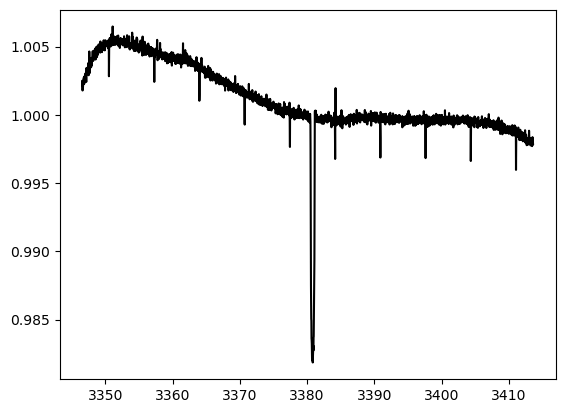

In [107]:
# Reading in the data and plotting it..
df = pd.read_csv('k2camp2.dat',sep='\t',names='time flux fluxerr inst'.split())

time_lc = (df['time'] - 2454833).values
flux = df['flux'].values
flux_error = df['fluxerr'].values

plt.plot(time_lc, flux, 'k')
# plt.xlim(3360, 3366)


{'index': 300, 'log_power': -17.212759762195446, 'period': 3.9063411523454086, 'period_uncert': 0.10191319428488589}


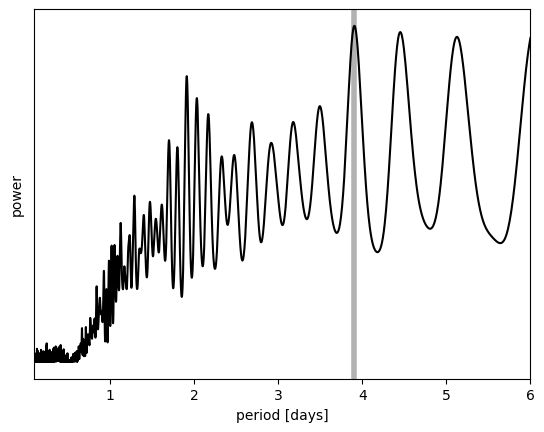

In [108]:
results = xo.estimators.lomb_scargle_estimator(
    time_lc, flux, max_peaks = 1, min_period = 0.1, max_period = 6, samples_per_peak = 50
)

peak = results["peaks"][0]
freq, power = results["periodogram"]
plt.plot(1 / freq, power, "k")
plt.axvline(peak["period"], color="k", lw=4, alpha=0.3)
plt.xlim((1 / freq).min(), (1 / freq).max())
plt.yticks([])
plt.xlabel("period [days]")
_ = plt.ylabel("power")
print(peak)


In [111]:
periods = [6.7252337648, 1000]
period_error = [0.1, 500]
t0s = [2457221.8349184883 - 2454833, 2458213.8222186137 - 2454833] #[2388.835, 3380.822]
t0_error = [0.1, 0.1]
duration = [0.9/24, 15.71/24]
nplanets = 2
R_star = [0.79,0.02] #in solar radii
M_star = [0.82,0.03] #in solar mass
Expected_msini = [1,1] #in earth units #caleb check
Teff = [4870, 88] #in Kelvin and uncertainty is +/- 88

Rsun2Rearth = (const.R_sun/const.R_earth).value
RsunPerDay = ((const.R_sun/u.d).to(u.m/u.s)).value
Rsun2AU = (const.R_sun).to(u.au).value

# RV Stuff
Ks = xo.estimate_semi_amplitude(periods, time, rad_vel, rv_err, t0s=t0s)


with pm.Model() as model:

    mean = pm.Normal("mean", mu=0.0, sigma = 1.0, testval = 1) #the mean of the lightcurve (approx 1)
    ustar = xo.distributions.QuadLimbDark("u")
    
    # Stellar parameters
    BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=1.5)
    m_star = BoundedNormal("m_star", mu=M_star[0], sd=M_star[1])
    r_star = BoundedNormal("r_star", mu=R_star[0], sd=R_star[1])
    teff = pm.Bound(pm.Normal, lower=2000, upper=7000)("teff", mu=Teff[0], sd=Teff[1])
    st_lum = pm.Deterministic("st_lum", (r_star**2) * ((teff/5777)**4)) #stellar luminosity #derived parameter
    star_params = [mean, ustar] 
    
    # Planet parameters
    ror = pm.Uniform("ror", lower=0.01, upper = 0.99, shape=nplanets) #, testval=np.array([0.04, 0.06]))
    r_pl = pm.Deterministic("r_pl", ror*r_star) #in physical units aka stellar radii #not a free parameter but you can calculate at every step
#     m_pl = pm.Uniform("m_pl", lower=0.1, upper=3e4, testval=Expected_msini, shape=nplanets)
#     # deterministic means values that were derived from the model
#     density_pl = pm.Deterministic("density_pl", m_pl/((r_pl*Rsun2Rearth)**3) * 5.514) # Convert from rho_earth to g/cm3

    # RV Stuff
    # Wide log-normal prior for semi-amplitude
    K = pm.Uniform(
        "K", lower = 1, upper = 1000, shape = nplanets)

    # Orbital parameters
    period = pm.Normal("period", mu = np.array(periods), sigma= np.array(period_error), shape=nplanets)
    t0 = pm.Normal("t0", mu=t0s, sigma=np.array(t0_error), shape=nplanets)
    b = pm.Uniform("b", lower = 0, upper = 1, shape=nplanets)
    
    # Set up the orbit
    #orbit = xo.orbits.KeplerianOrbit(period=period, ror = ror, duration=dur, t0=t0, b=b)


    ecs = pmx.UnitDisk("ecs", testval=np.array([[0.1, 0.1]] * nplanets).T, shape=(2, nplanets))
    ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2, axis=0))
    omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
    
    # RV Stuff Start
    #Jitter & a baseline for now RV trend 
    #each instrument will have its own rv offset aka trend
    RVOffset = pm.Normal("RVOffset",
                         mu=np.array([0]*len(merged_data.instrument.unique())), 
                         sigma=20000, 
                         shape=len(merged_data.instrument.unique()),) #offset relative to each instrument
    
    RVJitter = pm.Uniform("RVJitter", 1e-3,1e3, shape=len(merged_data.instrument.unique())) #adding additional noise
    
    RVMean = tt.zeros(merged_data.shape[0])
    RVError = tt.zeros(merged_data.shape[0])
    
    for i, inst in enumerate(merged_data.instrument.unique()):
        RVMean += RVOffset[i] * (merged_data.instrument == inst)
        RVError += tt.sqrt(rv_err**2 + RVJitter[i]**2) * (merged_data.instrument == inst)
        
    pm.Deterministic("RVMean", RVMean)
    pm.Deterministic("RVError", RVError)

    # RV Stuff End


    # Orbit model
    orbit = xo.orbits.KeplerianOrbit(r_star = r_star, m_star= m_star, 
                                     period = period, t0 = t0, b = b, 
                                     ecc = ecc, omega = omega) #, m_planet = xo.units.with_unit(m_pl, u.M_earth))
    pm.Deterministic("rho_circ", orbit.rho_star)
    pm.Deterministic("aor", orbit.a / r_star)

        # A function for computing the full RV model
    def get_rv_model(t, name=""):
        # First the RVs induced by the planets
        vrad = orbit.get_radial_velocity(t, K = K) 
        pm.Deterministic("vrad" + name, vrad)

        # Define the background model
#         A = np.vander(t - time_ref, trendshape)
#         bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

        # Sum over planets and add the background to get the full model
        return pm.Deterministic("rv_model" + name, tt.sum(vrad, axis=-1))
    
    # Define the RVs at the observed times
    rv_model = get_rv_model(time)
#     rv_model2 = get_rv_model(neidhe_time)
#     rv_model3 = get_rv_model(neidhr_time)

    # Also define the model on a fine grid as computed above (for plotting)
    rv_model_pred = get_rv_model(t, name="_pred")

    # Finally add in the observation model. This next line adds a new contribution
    # to the log probability of the PyMC3 model

    pm.Normal("obs", mu = rv_model, sd = RVError, observed = rad_vel - RVMean)
       
    
    # Set up the mean transit model
    star = xo.LimbDarkLightCurve(ustar)
    
    ### Calculates light curve for each planet at its time vector ###
    light_curves = star.get_light_curve(orbit=orbit, 
                                        r = r_pl, 
                                        t = time_lc, 
                                        texp = 29.4*u.min.to('d'))
    
    # Saves the individual lightcurves 
    pm.Deterministic("light_curves", light_curves) 
    
    ### Full photometric model, the sum of all transits + the baseline (mean) ###
    lc_model = mean + tt.sum(light_curves, axis=-1)
    
#     # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("transit_obs", mu=lc_model, sd=flux_error, observed=flux)

    
##################################################### GP MODEL ##################################################
##################################################### GP MODEL ##################################################
    

    # A jitter term describing excess white noise
    jitter = pm.Normal("jitter", mu = np.mean(flux_error), sigma = 0.5)
    
#     # The Parameters of the SHO Kernel 
    sigma = pm.InverseGamma(
        "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 6.0) 
    )
    rho = pm.InverseGamma(
        "rho", **pmx.estimate_inverse_gamma_parameters(1, 4)
    )
    # The Parameters of the RotationTerm Kernel 
    sigma_rot = pm.InverseGamma(
        "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
    )
    prot = pm.Normal("prot", mu = 3.9063411523454086, sigma = 0.10191319428488589) # 6.057719351364237, 0.21315980404897117 #0.2133955928082091
    Q0 = pm.Normal("Q0", mu = 4, sigma = 1) # mu = mean and sigma = std deviation
    dQ = pm.Normal("dQ", mu = 2, sigma = 1) 
    f = pm.Uniform("f", lower = 0.1, upper = 1.0)
    
    # The SHO Kernel
    kernel = terms.SHOTerm(sigma=sigma, rho=rho, Q = 1 / 3.0)
    
    # The Rotation Kernel
    kernel += terms.RotationTerm(
        sigma = sigma_rot,
        period = prot,
        Q0 = Q0,
        dQ = dQ,
        f = f,
    )
    
    gp = GaussianProcess(
        kernel,
        t = time_lc,
        diag = flux_error**2 + tt.exp(2 * jitter), #changed 
        mean = mean,
        quiet = True,
    )

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    
    gp.marginal("no_transit_lc", observed = flux - lc_model)

    # Compute the GP model prediction for plotting purposes
    pm.Deterministic("gp_pred", gp.predict(flux - lc_model))
    
    # Optimize the MAP solution.
    map_soln = model.test_point
    print(model.check_test_point())
    
    # Optimizing LC model
    map_soln = pmx.optimize(
        vars=[
            ror,
            b,
            t0,
            period,
            r_star,
            ustar,
            mean,
        ],
    )

    #Optimizing RV Model
    
    map_soln = pmx.optimize(map_soln, [RVJitter, RVOffset, K])
    map_soln = pmx.optimize(map_soln, vars = ecs)
    
    # Optimizing GP model ###### Optimizing GP model ###### Optimizing GP model ###### Optimizing GP model ###
    # SHO Kernel
    map_soln = pmx.optimize(vars=[sigma, rho]) # find the best values for my SHO #
    # Rotational Kernel
    map_soln = pmx.optimize(vars=[sigma_rot, f, prot, Q0, dQ])
        
        
    map_soln = pmx.optimize(map_soln)


mean                             -1.42
u_quadlimbdark__                 -2.77
m_star_interval__                -1.12
r_star_interval__                 0.01
teff_interval__                  -7.10
ror_interval__                   -2.77
K_interval__                     -2.77
period                           -5.75
t0                                2.77
b_interval__                     -2.77
ecs_unitdisk+interval__          -2.82
RVOffset                        -43.29
RVJitter_interval__              -5.55
jitter                           -0.23
sigma_log__                       0.00
rho_log__                         0.27
sigma_rot_log__                   0.11
prot                              1.36
Q0                               -0.92
dQ                               -0.92
f_interval__                     -1.39
obs                            -257.55
transit_obs               -25546447.71
no_transit_lc                 -3368.93
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [mean, u, r_star, period, t0, b, ror]


message: Desired error not necessarily achieved due to precision loss.
logp: -25550151.244025126 -> -91673.92361360887
optimizing logp for variables: [K, RVOffset, RVJitter]


message: Optimization terminated successfully.
logp: -91673.92361360887 -> -91633.00231882936
optimizing logp for variables: [ecs]


message: Optimization terminated successfully.
logp: -91633.00231882936 -> -91628.72030636377
optimizing logp for variables: [rho, sigma]


message: Optimization terminated successfully.
logp: -25550151.244025126 -> -25549967.461013153
optimizing logp for variables: [dQ, Q0, prot, f, sigma_rot]


message: Optimization terminated successfully.
logp: -25550151.244025126 -> -25550124.48012248
optimizing logp for variables: [f, dQ, Q0, prot, sigma_rot, rho, sigma, jitter, RVJitter, RVOffset, ecs, b, t0, period, K, ror, teff, r_star, m_star, u, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -25550124.48012248 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


In [112]:
print('*** MAP Fit Parameters ***')
for thiskey in list(map_soln.keys())[:-1]:
    if bool(thiskey.find('__')+1):
        continue
    print('{}: {}'.format(thiskey, map_soln[thiskey]))
    

*** MAP Fit Parameters ***
mean: 1.0
period: [   6.72523376 1000.        ]
t0: [2388.83491849 3380.82221861]
RVOffset: [0. 0. 0. 0.]
jitter: 0.00025979967377865793
prot: 3.937072792659474
Q0: 4.176989278181321
dQ: 2.124726893935179
u: [0.70710678 0.        ]
m_star: 0.75
r_star: 0.75
teff: 4500.0
st_lum: 0.2070918995632046
ror: [0.5 0.5]
r_pl: [0.375 0.375]
K: [500.5 500.5]
b: [0.5 0.5]
ecs: [[0.1 0.1]
 [0.1 0.1]]
ecc: [0.02 0.02]
omega: [0.78539816 0.78539816]
RVJitter: [500.0005 500.0005 500.0005 500.0005]
RVMean: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
RVError: [503.42976682 500.51827846 502.02256618 501.57034057 501.3785779
 500.79483153 501.69555989 510.83153014 503.05820916 500.9321943
 502.25075006 500.84357836 500.77587912 500.75573826 502.46436489
 500.24962776 500.17690362 500.49377545 500.07392755 500.30058672
 500.43344787 500.48690313 500.11815329 500.09794462 500.18872539
 500.29827392 500.08968707 500.0491946 

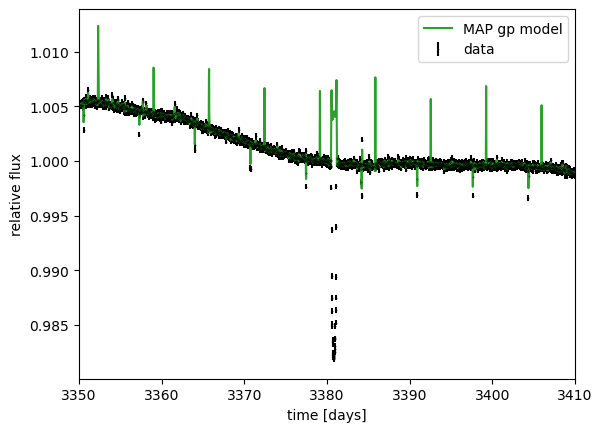

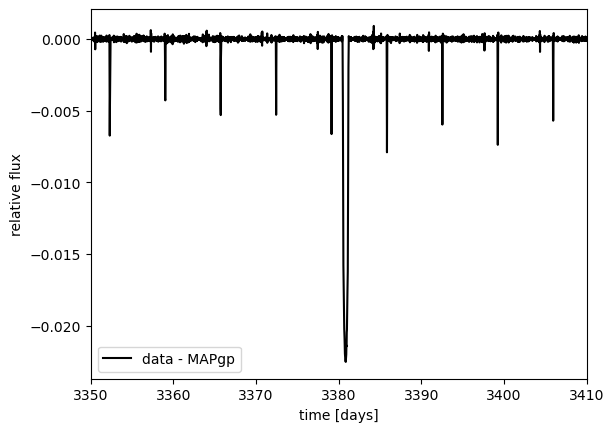

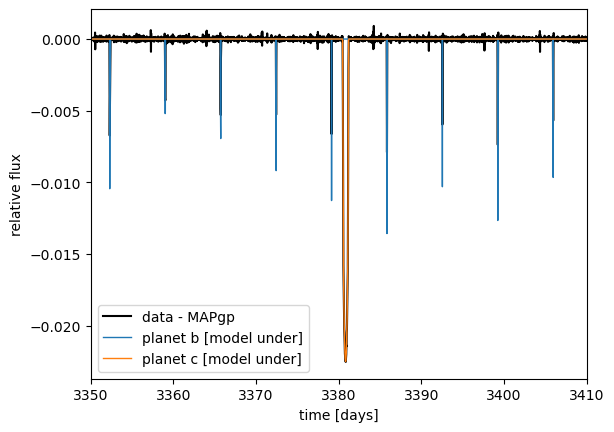

In [98]:
gp_mod = map_soln["gp_pred"] + map_soln["mean"]

plt.figure()
plt.errorbar(time_lc, flux, yerr = flux_error, color = 'k', marker = ".", linestyle = 'none', ms=0.5, label="data")
plt.plot(time_lc, gp_mod, color="C2", label="MAP gp model")
# for i, l in enumerate("bc"):
#     plt.plot(
#         time, map_soln["light_curves"][:,i]+map_soln["mean"], lw=1, label="planet {0}".format(l)
#     )
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(3350, 3410)
#plt.ylim(0.99, 1.16)
plt.legend(fontsize=10)

plt.figure()
plt.plot(time_lc, flux - gp_mod, "k", label = "data - MAPgp")
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(3350, 3410)
plt.legend(fontsize=10)

plt.figure()
plt.plot(time_lc, flux - gp_mod, "k", label="data - MAPgp")

for i, l in enumerate("bc"):
    mod = map_soln["light_curves"][:, i]
    plt.plot(time_lc, mod, lw = 1, label="planet {0} [model under]".format(l))
    
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(3350, 3410)
# plt.xlim(3354, 3360)
plt.legend(fontsize=10)

## Phase Plot ##

In [15]:
# # Plot the folded transit
# fig, ax = plt.subplots(figsize=(10, 5))

# period = 6.7252337648

# t0 = 2457221.8349184883 - 2454833 #[2388.835, 3380.822]



# x_fold = (time - t0 + 0.5 * period) % period - 0.5 * period
# m = np.abs(x_fold) < 0.5
# ax.scatter(
#     x_fold[m],
#     1e3 * (flux[m] - map_soln["gp_pred"][m]),
#     c="k",
#     marker=".",
#     alpha=0.2,
#     linewidths=0,
# )

# lc_mod = lc_model[:, 0]
# lc_modx = np.sort(x_fold)
# lc_mody = lc_mod[np.argsort(x_fold)]
# ax.plot(lc_modx, 1e3 * (lc_mody + map_soln["mean"]), c="purple", zorder=1)

# # Overplot the phase binned light curve
# bins = np.linspace(-0.51, 0.51, 100)
# denom, _ = np.histogram(x_fold, bins)
# num, _ = np.histogram(x_fold, bins, weights= flux - map_soln["gp_pred"])
# denom[num == 0] = 1.0
# ax.scatter(
#     0.5 * (bins[1:] + bins[:-1]),
#     1e3 * num / denom,
#     color="C1",
#     zorder=2,
#     linewidths=0,
# )

# ax.set_xlim(-0.5, 0.5)
# ax.set_ylim(-3, 0.5)
# ax.set_ylabel("de-trended flux [ppt]")
# _ = ax.set_xlabel("time since transit")

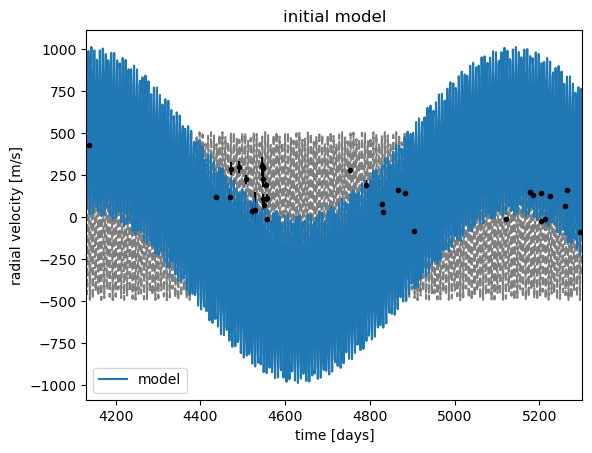

In [113]:
plt.errorbar(time, rad_vel-map_soln['RVMean'], yerr = rv_err, fmt=".k")

with model:
    plt.plot(t, pmx.eval_in_model(model.vrad_pred), "--k", alpha= 0.5)
#     plt.plot(t, pmx.eval_in_model(model.bkg_pred), ":k", alpha=0.5, zorder = 100)
    plt.plot(t, pmx.eval_in_model(model.rv_model_pred),label="model")


plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
#plt.xlim(4550,4560)
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("initial model")